# Question # 1

###  Preprocessing & Tokenizing `(Byte-Pair Encoding)` Dataset

In [ ]:
import os

# Set the main directory for datasets
dataset_root = "umc005-corpus"
quran_folder = os.path.join(dataset_root, "quran")
bible_folder = os.path.join(dataset_root, "bible")

# Helper function to read aligned sentence pairs from file paths
def read_parallel_corpus(english_path, urdu_path):
    with open(english_path, "r", encoding="utf-8") as file_en, open(urdu_path, "r", encoding="utf-8") as file_ur:
        en_lines = file_en.readlines()
        ur_lines = file_ur.readlines()

    assert len(en_lines) == len(ur_lines), "Line count mismatch between English and Urdu files."
    paired_sentences = list(zip(en_lines, ur_lines))
    return paired_sentences

# Load Quran dataset
train_quran = read_parallel_corpus(os.path.join(quran_folder, "train.en"), os.path.join(quran_folder, "train.ur"))
test_quran = read_parallel_corpus(os.path.join(quran_folder, "test.en"), os.path.join(quran_folder, "test.ur"))
dev_quran = read_parallel_corpus(os.path.join(quran_folder, "dev.en"), os.path.join(quran_folder, "dev.ur"))

# Load Bible dataset
train_bible = read_parallel_corpus(os.path.join(bible_folder, "train.en"), os.path.join(bible_folder, "train.ur"))
test_bible = read_parallel_corpus(os.path.join(bible_folder, "test.en"), os.path.join(bible_folder, "test.ur"))
dev_bible = read_parallel_corpus(os.path.join(bible_folder, "dev.en"), os.path.join(bible_folder, "dev.ur"))


In [ ]:
import os
import sentencepiece as spm

# Function to clean English text
def preprocess_english(text_line):
    text_line = text_line.strip().lower()  # Convert to lowercase and trim spaces
    return text_line

# Define main directories for UMC005 dataset
corpus_root = "umc005-corpus"
quran_path = os.path.join(corpus_root, "quran")
bible_path = os.path.join(corpus_root, "bible")

# Function to read aligned data from English and Urdu files
def read_aligned_sentences(path_en, path_ur):
    with open(path_en, "r", encoding="utf-8") as file_en, open(path_ur, "r", encoding="utf-8") as file_ur:
        lines_en = file_en.readlines()
        lines_ur = file_ur.readlines()

    assert len(lines_en) == len(lines_ur), "The English and Urdu files have different line counts."
    paired_data = list(zip(lines_en, lines_ur))
    return paired_data

# Function to aggregate all parallel data
def aggregate_parallel_corpus():
    aligned_pairs = []
    quran_data = read_aligned_sentences(os.path.join(quran_path, "Quran-EN"), os.path.join(quran_path, "Quran-UR-normalized"))
    bible_data = read_aligned_sentences(os.path.join(bible_path, "Bible-EN"), os.path.join(bible_path, "Bible-UR-normalized"))
    aligned_pairs.extend(quran_data + bible_data)
    return aligned_pairs

# Function to generate a unified parallel data file
def write_parallel_corpus_to_file(sentence_pairs, output_filename):
    with open(output_filename, "w", encoding="utf-8") as output_file:
        for eng_sentence, ur_sentence in sentence_pairs:
            processed_eng = preprocess_english(eng_sentence)  # Clean the English sentence
            output_file.write(processed_eng + "\n")  # Write cleaned English text
            output_file.write(ur_sentence.strip() + "\n")  # Write Urdu text without extra spaces

# Prepare and save the combined dataset
merged_data = aggregate_parallel_corpus()
output_corpus_file = "urdu_english_combined_parallel.txt"
write_parallel_corpus_to_file(merged_data, output_corpus_file)

# Train the SentencePiece model on the combined dataset
spm.SentencePieceTrainer.train(
    input=output_corpus_file,
    model_prefix="bpe_tokenizer_urdu_english",
    vocab_size=32000,  # Set desired vocabulary size
    model_type="bpe",  # Use Byte-Pair Encoding for tokenization
    character_coverage=0.9995,  # High coverage to include all characters
    input_sentence_size=50000,  # Limit sentences for faster training
    shuffle_input_sentence=True
)

# Load the trained SentencePiece model
tokenizer = spm.SentencePieceProcessor(model_file="bpe_tokenizer_urdu_english.model")

# Example of tokenizing a sample sentence
test_sentence = "Sample text in English or Urdu for tokenization"
tokenized_output = tokenizer.encode(test_sentence, out_type=str)
print("Tokenized text:", tokenized_output)


Tokenized text: ['▁', 'S', 'am', 'ple', '▁te', 'xt', '▁in', '▁', 'E', 'ng', 'lish', '▁or', '▁', 'U', 'rd', 'u', '▁for', '▁token', 'iz', 'ation']


## Transformer Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import math


# Multi-Head Attention module
class MultiHeadedAttention(nn.Module):
    def __init__(self, model_dim, num_attention_heads):
        super(MultiHeadedAttention, self).__init__()
        assert model_dim % num_attention_heads == 0, "model_dim must be divisible by num_attention_heads"
        self.head_dim = model_dim // num_attention_heads
        self.num_heads = num_attention_heads

        # Define linear layers for query, key, and value projections
        self.linear_query = nn.Linear(model_dim, model_dim)
        self.linear_key = nn.Linear(model_dim, model_dim)
        self.linear_value = nn.Linear(model_dim, model_dim)
        self.output_linear = nn.Linear(model_dim, model_dim)

    def forward(self, queries, keys, values, attention_mask=None):
        batch_size = queries.size(0)

        # Project queries, keys, and values
        queries = self.linear_query(queries).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        keys = self.linear_key(keys).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        values = self.linear_value(values).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        # Compute attention scores with scaled dot-product attention
        scaled_scores = torch.matmul(queries, keys.transpose(-2, -1)) / math.sqrt(self.head_dim)
        if attention_mask is not None:
            scaled_scores = scaled_scores.masked_fill(attention_mask == 0, float('-inf'))

        # Apply softmax to get attention weights
        attention_weights = F.softmax(scaled_scores, dim=-1)
        attention_output = torch.matmul(attention_weights, values)

        # Concatenate the attention output from all heads
        concatenated_output = attention_output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.head_dim)
        return self.output_linear(concatenated_output)



In [ ]:
# Positional Encoding module for adding temporal/spatial information
class PositionEncoding(nn.Module):
    def __init__(self, model_dim, max_sequence_length=5000):
        super(PositionEncoding, self).__init__()
        self.position_encodings = torch.zeros(max_sequence_length, model_dim)
        pos_indices = torch.arange(0, max_sequence_length).unsqueeze(1)
        frequency_term = torch.exp(torch.arange(0, model_dim, 2) * -(math.log(10000.0) / model_dim))

        # Compute sine and cosine values for positional encodings
        self.position_encodings[:, 0::2] = torch.sin(pos_indices * frequency_term)
        self.position_encodings[:, 1::2] = torch.cos(pos_indices * frequency_term)
        self.position_encodings = self.position_encodings.unsqueeze(0)

    def forward(self, input_tensor):
        seq_length = input_tensor.size(1)
        # Add positional encodings to the input tensor
        return input_tensor + self.position_encodings[:, :seq_length, :].to(input_tensor.device)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Feed-Forward Network module used in Transformer
class TransformerFeedForward(nn.Module):
    def __init__(self, model_dim, ff_dim, dropout_rate=0.1):
        super(TransformerFeedForward, self).__init__()
        self.fc1 = nn.Linear(model_dim, ff_dim)
        self.dropout_layer = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(ff_dim, model_dim)

    def forward(self, input_tensor):
        # Apply first linear layer, followed by ReLU activation and dropout, then second linear layer
        intermediate_output = F.relu(self.fc1(input_tensor))
        dropped_output = self.dropout_layer(intermediate_output)
        final_output = self.fc2(dropped_output)
        return final_output


In [ ]:
# Transformer Encoder Layer
class TransformerEncoderLayer(nn.Module):
    def __init__(self, model_dim, num_attention_heads, ff_dim, dropout_rate=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attention = MultiHeadedAttention(model_dim, num_attention_heads)
        self.feed_forward = TransformerFeedForward(model_dim, ff_dim, dropout_rate)
        self.layer_norm1 = nn.LayerNorm(model_dim)
        self.layer_norm2 = nn.LayerNorm(model_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, input_tensor, attention_mask=None):
        # Self-Attention with residual connection and layer normalization
        attention_output = self.self_attention(input_tensor, input_tensor, input_tensor, attention_mask)
        normed_attention_output = self.layer_norm1(input_tensor + self.dropout(attention_output))

        # Feed-Forward with residual connection and layer normalization
        ff_output = self.feed_forward(normed_attention_output)
        final_output = self.layer_norm2(normed_attention_output + self.dropout(ff_output))
        return final_output

# Transformer Encoder Module
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, model_dim, num_attention_heads, num_encoder_layers, ff_dim, max_sequence_length, dropout_rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.embedding_layer = nn.Embedding(vocab_size, model_dim)
        self.position_encoding = PositionEncoding(model_dim, max_sequence_length)
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(model_dim, num_attention_heads, ff_dim, dropout_rate)
            for _ in range(num_encoder_layers)
        ])

    def forward(self, input_indices, attention_mask=None):
        # Apply embedding and scale by the square root of model dimension
        embeddings = self.embedding_layer(input_indices) * math.sqrt(self.embedding_layer.embedding_dim)
        embeddings = self.position_encoding(embeddings)

        # Pass through each encoder layer
        for encoder_layer in self.encoder_layers:
            embeddings = encoder_layer(embeddings, attention_mask)

        return embeddings


In [ ]:
# Transformer Decoder Layer
class TransformerDecoderLayer(nn.Module):
    def __init__(self, model_dim, num_attention_heads, ff_dim, dropout_rate=0.1):
        super(TransformerDecoderLayer, self).__init__()
        self.self_attention = MultiHeadedAttention(model_dim, num_attention_heads)
        self.encoder_decoder_attention = MultiHeadedAttention(model_dim, num_attention_heads)
        self.feed_forward = TransformerFeedForward(model_dim, ff_dim, dropout_rate)
        self.layer_norm1 = nn.LayerNorm(model_dim)
        self.layer_norm2 = nn.LayerNorm(model_dim)
        self.layer_norm3 = nn.LayerNorm(model_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, target_tensor, encoder_output, source_mask=None, target_mask=None):
        # Self-attention with residual connection and layer normalization
        self_attention_output = self.self_attention(target_tensor, target_tensor, target_tensor, target_mask)
        normed_self_attention_output = self.layer_norm1(target_tensor + self.dropout(self_attention_output))

        # Encoder-decoder attention with residual connection and layer normalization
        enc_dec_attention_output = self.encoder_decoder_attention(normed_self_attention_output, encoder_output, encoder_output, source_mask)
        normed_enc_dec_output = self.layer_norm2(normed_self_attention_output + self.dropout(enc_dec_attention_output))

        # Feed-forward network with residual connection and layer normalization
        ff_output = self.feed_forward(normed_enc_dec_output)
        final_output = self.layer_norm3(normed_enc_dec_output + self.dropout(ff_output))
        return final_output

# Transformer Decoder Module
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, model_dim, num_attention_heads, num_decoder_layers, ff_dim, max_sequence_length, dropout_rate=0.1):
        super(TransformerDecoder, self).__init__()
        self.embedding_layer = nn.Embedding(vocab_size, model_dim)
        self.position_encoding = PositionEncoding(model_dim, max_sequence_length)
        self.decoder_layers = nn.ModuleList([
            TransformerDecoderLayer(model_dim, num_attention_heads, ff_dim, dropout_rate)
            for _ in range(num_decoder_layers)
        ])

    def forward(self, target_indices, encoder_output, source_mask=None, target_mask=None):
        # Apply embedding and scale by the square root of model dimension
        target_embeddings = self.embedding_layer(target_indices) * math.sqrt(self.embedding_layer.embedding_dim)
        target_embeddings = self.position_encoding(target_embeddings)

        # Pass through each decoder layer
        for decoder_layer in self.decoder_layers:
            target_embeddings = decoder_layer(target_embeddings, encoder_output, source_mask, target_mask)

        return target_embeddings


In [56]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, src_pad_idx, tgt_pad_idx, d_model, num_heads, num_layers, d_ff, max_len, dropout=0.1):
        super(Transformer, self).__init__()
        self.src_pad_idx = src_pad_idx
        self.tgt_pad_idx = tgt_pad_idx
        self.encoder = Encoder(src_vocab_size, d_model, num_heads, num_layers, d_ff, max_len, dropout)
        self.decoder = Decoder(tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_len, dropout)
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)

    def make_src_mask(self, src):
        # Create mask for source
        return (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

    def make_tgt_mask(self, tgt):
        # Create mask for target (with causal mask for decoding)
        tgt_pad_mask = (tgt != self.tgt_pad_idx).unsqueeze(1).unsqueeze(2)
        tgt_len = tgt.size(1)
        tgt_subseq_mask = torch.tril(torch.ones((tgt_len, tgt_len), device=tgt.device)).bool()
        return tgt_pad_mask & tgt_subseq_mask

    def forward(self, src, tgt):
        src_mask = self.make_src_mask(src)
        tgt_mask = self.make_tgt_mask(tgt)
        enc_output = self.encoder(src, src_mask)
        dec_output = self.decoder(tgt, enc_output, src_mask, tgt_mask)
        output = self.fc_out(dec_output)
        return output


In [ ]:
import sentencepiece as spm
import torch
from torch.utils.data import DataLoader, Dataset

# Load the trained tokenizer
sentence_tokenizer = spm.SentencePieceProcessor()
sentence_tokenizer.load("urdu_english_bpe_parallel.model")

# Define max sequence length and padding index
MAX_SEQUENCE_LENGTH = 50
PADDING_INDEX = sentence_tokenizer.piece_to_id("<pad>")

# Function to tokenize and pad the sentences
def tokenize_and_pad_sentences(sentences):
    tokenized_sentences = [sentence_tokenizer.encode(sentence, out_type=int) for sentence in sentences]
    padded_sentences = [
        seq[:MAX_SEQUENCE_LENGTH] + [PADDING_INDEX] * (MAX_SEQUENCE_LENGTH - len(seq)) if len(seq) < MAX_SEQUENCE_LENGTH else seq[:MAX_SEQUENCE_LENGTH]
        for seq in tokenized_sentences
    ]
    return padded_sentences

# Function to load sentences from file
def load_sentences_from_file(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        return file.readlines()

# Load training data
english_train_sentences = load_sentences_from_file("umc005-corpus/quran/train.en") + load_sentences_from_file("umc005-corpus/bible/train.en")
urdu_train_sentences = load_sentences_from_file("umc005-corpus/quran/train.ur") + load_sentences_from_file("umc005-corpus/bible/train.ur")

# Tokenize and prepare the data
source_data = tokenize_and_pad_sentences(english_train_sentences)
target_data = tokenize_and_pad_sentences(urdu_train_sentences)


In [ ]:
# Translation Dataset class for paired source and target data
class ParallelTextDataset(Dataset):
    def __init__(self, source_data, target_data):
        self.source_data = source_data
        self.target_data = target_data

    def __len__(self):
        return len(self.source_data)

    def __getitem__(self, index):
        return torch.tensor(self.source_data[index]), torch.tensor(self.target_data[index])

# Create the dataset and dataloader
parallel_text_dataset = ParallelTextDataset(source_data, target_data)
data_loader = DataLoader(parallel_text_dataset, batch_size=2, shuffle=True)


#### Hyperparameters & Model Initialization

In [ ]:
# Define model hyperparameters
model_dim = 128
num_attention_heads = 2
num_encoder_decoder_layers = 2
feed_forward_dim = 512
max_sequence_length = 200
dropout_rate = 0.1

# Assuming the tokenizer is defined and PAD_IDX is already provided
source_vocab_size = tokenizer.get_piece_size()
target_vocab_size = tokenizer.get_piece_size()

# Initialize the Transformer model
transformer_model = TransformerModel(
    source_vocab_size=source_vocab_size,
    target_vocab_size=target_vocab_size,
    source_pad_token_idx=PAD_IDX,  # Source padding index
    target_pad_token_idx=PAD_IDX,  # Target padding index
    model_dim=model_dim,
    num_attention_heads=num_attention_heads,
    num_layers=num_encoder_decoder_layers,
    ff_dim=feed_forward_dim,
    max_sequence_length=max_sequence_length,
    dropout_rate=dropout_rate
)

# Define loss function with padding ignored
loss_criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

# Optimizer
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.0001)


#### **Training the custom transformer** 

In [ ]:
# Set device to GPU if available, otherwise use CPU
training_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the appropriate device
transformer_model.to(training_device)

num_epochs = 20

for epoch in range(num_epochs):
    transformer_model.train()
    total_epoch_loss = 0

    for source_batch, target_batch in dataloader:
        # Move data to the appropriate device
        source_input = source_batch.to(training_device)
        target_input = target_batch[:, :-1].to(training_device)  # Exclude last token
        target_output = target_batch[:, 1:].to(training_device)  # Exclude first token

        # Forward pass
        predicted_logits = transformer_model(source_input, target_input)

        # Compute loss
        loss = loss_criterion(predicted_logits.view(-1, predicted_logits.size(-1)), target_output.view(-1))
        total_epoch_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_epoch_loss / len(dataloader)}")


Epoch 1/20, Loss: 5.847795763905369
Epoch 2/20, Loss: 4.914523594290463
Epoch 3/20, Loss: 4.5751000347600055
Epoch 4/20, Loss: 4.352262926599873
Epoch 5/20, Loss: 4.184005458959892
Epoch 6/20, Loss: 4.042845732934439
Epoch 7/20, Loss: 3.918032662388104
Epoch 8/20, Loss: 3.8128471590867683
Epoch 9/20, Loss: 3.7139017724457073
Epoch 10/20, Loss: 3.621993897566155
Epoch 11/20, Loss: 3.534025015350598
Epoch 12/20, Loss: 3.4561936408325806
Epoch 13/20, Loss: 3.383977654051425
Epoch 14/20, Loss: 3.312921400176945
Epoch 15/20, Loss: 3.2490196408353635
Epoch 16/20, Loss: 3.184731990588245
Epoch 17/20, Loss: 3.1271846369531615
Epoch 18/20, Loss: 3.0695784538717414
Epoch 19/20, Loss: 3.020777788633731
Epoch 20/20, Loss: 2.9712336649378734


In [ ]:
torch.save(transformer_model.state_dict(), "transformer_translation1.pth")

In [ ]:
def translate(transformer_model, tokenizer, input_sentence, max_len=50):
    transformer_model.eval()  # Set model to evaluation mode
    
    # Tokenize the input English sentence
    source_tokens = tokenizer.encode(input_sentence, out_type=int)
    source_tokens = source_tokens[:max_len] + [PAD_IDX] * (max_len - len(source_tokens))  # Pad to max_len
    source_input = torch.tensor(source_tokens).unsqueeze(0).to(training_device)  # Add batch dimension and move to device

    # Generate translation using the model
    with torch.no_grad():
        output_tokens = transformer_model(source_input, source_input)  # Forward pass (translation)

        # If output is logits, apply argmax to get token IDs
        if isinstance(output_tokens, torch.Tensor):
            output_tokens = torch.argmax(output_tokens, dim=-1)  # Get the predicted token IDs

    # Decode token IDs to Urdu text
    translated_text = tokenizer.decode(output_tokens.squeeze().tolist())  # Convert token IDs to text
    return translated_text

# Example usage
english_input = "In the name of Allah, the Most Gracious, the Most Merciful."
urdu_translation = translate(transformer_model, tokenizer, english_input)
print("Translation:", urdu_translation)


Translation: باتیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں


## Model Evaluation

In [ ]:
import torch
import nltk
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
import sentencepiece as spm


# Initialize the tokenizer
class Tokenizer:
    def __init__(self, model_path, max_seq_len=50):
        self.tokenizer = spm.SentencePieceProcessor()
        self.tokenizer.load(model_path)
        self.MAX_SEQ_LEN = max_seq_len
        self.PAD_IDX = self.tokenizer.piece_to_id("<pad>")
        self.SOS_IDX = self.tokenizer.piece_to_id("<sos>")
        self.EOS_IDX = self.tokenizer.piece_to_id("<eos>")

    def tokenize_and_prepare(self, sentences):
        tokenized = [self.tokenizer.encode(sentence, out_type=int) for sentence in sentences]
        padded = [seq[:self.MAX_SEQ_LEN] + [self.PAD_IDX] * (self.MAX_SEQ_LEN - len(seq)) 
                  if len(seq) < self.MAX_SEQ_LEN else seq[:self.MAX_SEQ_LEN] for seq in tokenized]
        return padded

    def decode_tokens(self, tokens):
        return self.tokenizer.decode(tokens)


# Load test data
def load_test_data(en_file, ur_file):
    with open(en_file, 'r', encoding='utf-8') as f:
        source_sentences = f.readlines()
    with open(ur_file, 'r', encoding='utf-8') as f:
        reference_sentences = f.readlines()
    return source_sentences, reference_sentences


# BLEU score calculation
def calculate_bleu(reference, hypothesis):
    reference = [nltk.word_tokenize(reference.strip())]
    hypothesis = nltk.word_tokenize(hypothesis.strip())
    return sentence_bleu(reference, hypothesis)


# ROUGE score calculation
def calculate_rouge(reference, hypothesis):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    return scorer.score(reference.strip(), hypothesis.strip())


# Evaluate the model on the test set
def evaluate_model(model, tokenizer, en_file, ur_file, device):
    model.eval()
    source_sentences, reference_sentences = load_test_data(en_file, ur_file)

    total_bleu = 0
    total_rouge1 = 0
    total_rougeL = 0
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

    for i, (source, reference) in enumerate(zip(source_sentences, reference_sentences)):
        # Tokenize and prepare input
        source_tensor = torch.tensor(tokenizer.tokenize_and_prepare([source]), dtype=torch.long).to(device)
        tgt_tensor = torch.full((source_tensor.size(0), tokenizer.MAX_SEQ_LEN), tokenizer.SOS_IDX, dtype=torch.long).to(device)

        with torch.no_grad():
            # Get model prediction
            output = model(source_tensor, tgt_tensor)
            prediction_ids = output.argmax(dim=-1).squeeze().tolist()
            hypothesis = tokenizer.decode_tokens(prediction_ids)

        # Calculate BLEU score
        bleu_score = calculate_bleu(reference, hypothesis)
        total_bleu += bleu_score

        # Calculate ROUGE scores
        rouge_scores = calculate_rouge(reference, hypothesis)
        total_rouge1 += rouge_scores['rouge1'].fmeasure
        total_rougeL += rouge_scores['rougeL'].fmeasure

        # Print example predictions for the first 5
        if i < 5:
            print(f"Source: {source.strip()}")
            print(f"Reference: {reference.strip()}")
            print(f"Hypothesis: {hypothesis.strip()}")
            print(f"BLEU: {bleu_score:.4f}, ROUGE-1: {rouge_scores['rouge1'].fmeasure:.4f}, ROUGE-L: {rouge_scores['rougeL'].fmeasure:.4f}\n")

    # Calculate and print average scores
    num_samples = len(source_sentences)
    avg_bleu = total_bleu / num_samples
    avg_rouge1 = total_rouge1 / num_samples
    avg_rougeL = total_rougeL / num_samples

    print(f"Average BLEU Score: {avg_bleu:.4f}")
    print(f"Average ROUGE-1 Score: {avg_rouge1:.4f}")
    print(f"Average ROUGE-L Score: {avg_rougeL:.4f}")

    return avg_bleu, avg_rouge1, avg_rougeL


# Example usage
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    en_file = "umc005-corpus/bible/test.en"
    ur_file = "umc005-corpus/bible/test.ur"

    tokenizer = Tokenizer(model_path="urdu_english_bpe_parallel.model")
    
    # Assuming the trained model is loaded as `model`
    avg_bleu, avg_rouge1, avg_rougeL = evaluate_model(model, tokenizer, en_file, ur_file, device)


Source: And to them it was given that they should not kill them , but that they should be tormented five months : and their torment was as the torment of a scorpion , when he striketh a man .
Reference: اور انہیں جان سے مارنے کا نہیں بلکہ پانچ مہینے تک لوگوں کو اذیت دینے کا اختیار دیا گیا اور ان کی اذیت ایسی تھی جیسے بچھو کے ڈنک مارنے سے آدمی کو ہوتی ہے ۔
Hypothesis: کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو
BLEU: 0.0000, ROUGE-1: 0.0000, ROUGE-L: 0.0000

Source: And in those days shall men seek death , and shall not find it ; and shall desire to die , and death shall flee from them .
Reference: ان دنوں میں آدمی موت ڈھونڈیں گے مگر ہرگز نہ پائیں گے اور مرنے کی آرزو کریں گے اور موت ان سے بھاگے گی ۔
Hypothesis: ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔
BLEU: 0.0000, ROUGE-1: 0.0000, ROUGE-L: 0.0000

Source: And the shapes of 

## Loss Curve

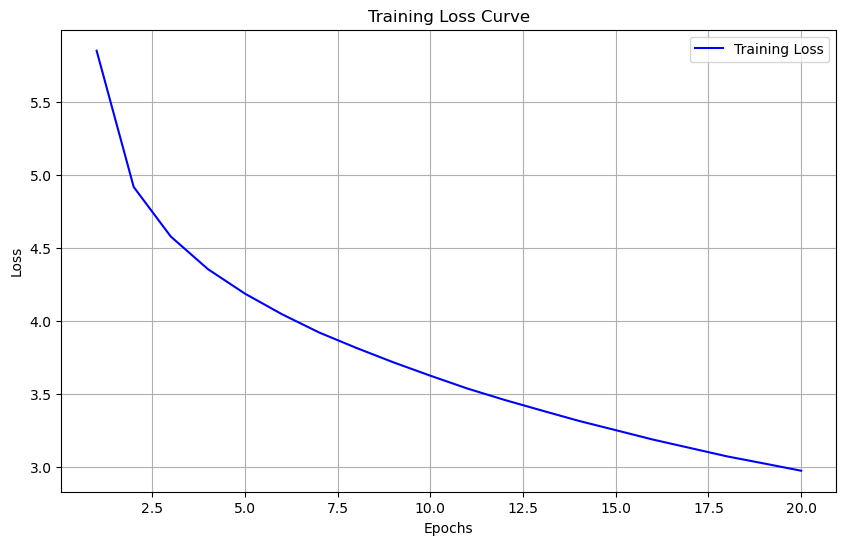

In [111]:
import matplotlib.pyplot as plt

# Loss values from your training output (replace with the actual loss values you have)
train_losses = [
    5.847795763905369, 4.914523594290463, 4.5751000347600055, 4.352262926599873,
    4.184005458959892, 4.042845732934439, 3.918032662388104, 3.8128471590867683,
    3.7139017724457073, 3.621993897566155, 3.534025015350598, 3.4561936408325806,
    3.383977654051425, 3.312921400176945, 3.2490196408353635, 3.184731990588245,
    3.1271846369531615, 3.0695784538717414, 3.020777788633731, 2.9712336649378734
]

# Plotting the training loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='blue')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()


## Fine Tuning Pretrained Model

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer
from torch.utils.data import DataLoader, Dataset

# Define the BERT model and tokenizer setup in a separate class
class BertModel:
    def __init__(self, model_name='bert-base-uncased', num_labels=2):
        self.model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        self.tokenizer = BertTokenizer.from_pretrained(model_name)

    def get_model(self):
        return self.model

    def get_tokenizer(self):
        return self.tokenizer


# Dataset class for preparing the data
class MyDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=32):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = self.texts[item]
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text, 
            add_special_tokens=True, 
            max_length=self.max_length, 
            padding='max_length', 
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


# Define the training loop function
def train_model(model, train_loader, optimizer, loss_fn, epochs=3, device='cpu'):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            # Move data to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            
            # Backward pass
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}")


# Example usage of the refactored code
if __name__ == "__main__":
    # Sample data
    texts = ["I love machine learning", "I hate bugs"]
    labels = [1, 0]  # 1 = positive, 0 = negative

    # Initialize the BERT model and tokenizer
    bert_model = BertModel()
    model = bert_model.get_model().to(device)  # Ensure to use the appropriate device (CPU or GPU)
    tokenizer = bert_model.get_tokenizer()

    # Prepare dataset and dataloader
    dataset = MyDataset(texts, labels, tokenizer, max_length=32)
    train_loader = DataLoader(dataset, batch_size=2)

    # Set up optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
    loss_fn = torch.nn.CrossEntropyLoss()

    # Train the model
    train_model(model, train_loader, optimizer, loss_fn, epochs=3, device=device)

    # Evaluation (for example, on a validation set)
    model.eval()


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

c:\Users\javer\Anaconda3\envs\pymc5_env\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\javer\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-un

Epoch 1, Loss: 0.7043259739875793
Epoch 2, Loss: 0.75309818983078
Epoch 3, Loss: 0.6424257159233093


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e